# End2end ConvRNN

> Autoencoder + forecaster in the same training loop. Based on (https://github.com/tcapelle/moving_mnist/blob/master/01_train_example.ipynb) and (https://github.com/tcapelle/moving_mnist/blob/master/02_train_cross_entropy_loss-Copy1.ipynb)

In [1]:
import sys
sys.path.append('..')
from fastai.vision.all import *
from mocatml.utils import *
convert_uuids_to_indices()
from mocatml.data import *
from mocatml.models.conv_rnn import *
from mygrad import sliding_window_view
from tsai.imports import my_setup
from tsai.utils import yaml2dict, dict2attrdict
my_setup()
from fastai.callback.schedule import valley, steep
from fastai.callback.wandb import WandbCallback
import wandb

os              : Linux-5.10.197-llgrid-x86_64-with-glibc2.35
python          : 3.9.15
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
torch           : 1.13.1+cu116
device          : 2 gpus (['Tesla V100-PCIE-32GB', 'Tesla V100-PCIE-32GB'])
cpu cores       : 40
threads per cpu : 2
RAM             : 377.57 GB
GPU memory      : N/A


In [2]:
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_base.convrnn = yaml2dict('./config/convrnn.yaml', attrdict=True)
#config = AttrDict({**config_base, **config_e2e})
config = AttrDict(config_base)
config

```json
{ 'bs': 64,
  'convrnn': {'dropout': 0.2},
  'data': {'path': '~/arclab_shared/mc_density_data/comb_am_rp.npy'},
  'device': 'cuda',
  'horizon': 4,
  'lookback': 4,
  'lr_max': 0.001,
  'mmap': 'True,',
  'n_epoch': 5,
  'seed': 42,
  'sel_steps': 200,
  'stride': 5,
  'tmp_folder': 'tmp',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': False,
             'mode': 'offline',
             'project': 'mocatml'}}
```

In [3]:
# Set device
default_device(0 if config.device == 'cpu' else config.device)

device(type='cuda', index=0)

In [4]:
run = wandb.init(project=config.wandb.project, 
                 config=config,
                 group=config.wandb.group,
                 mode=config.wandb.mode, 
                 anonymous='never') if config.wandb.enabled else None
config = dict2attrdict(run.config) if config.wandb.enabled else config
print(config)

{'bs': 64, 'data': {'path': '~/arclab_shared/mc_density_data/comb_am_rp.npy'}, 'device': 'cuda', 'horizon': 4, 'lr_max': 0.001, 'lookback': 4, 'mmap': 'True,', 'n_epoch': 5, 'seed': 42, 'sel_steps': 200, 'stride': 5, 'tmp_folder': 'tmp', 'wandb': {'enabled': False, 'log_learner': False, 'mode': 'offline', 'group': None, 'project': 'mocatml'}, 'convrnn': {'dropout': 0.2}}


In [5]:
data = np.load(Path(config.data.path).expanduser(), 
               mmap_mode='c' if config.mmap else None)
data = data[:, :config.sel_steps]
data.shape

(100, 200, 36, 99)

In [6]:
# Split by simulation
splits = RandomSplitter()(data)
splits

((#80) [75,8,33,36,41,27,10,68,74,60...],
 (#20) [20,22,26,7,38,92,29,53,45,76...])

In [7]:
data_sw = sliding_window_view(data, (data.shape[0], config.lookback + config.horizon, 
                                 data.shape[-2], data.shape[-1]), 
                                 (data.shape[0], config.stride, 
                                  data.shape[-2], data.shape[-1]))
samples_per_simulation = data_sw.shape[1]
data_sw = data_sw.squeeze().transpose([1,0,2,3,4])
data_sw = data_sw.reshape(-1, *data_sw.shape[2:])
data_sw.shape

(3900, 8, 36, 99)

(4, 4)

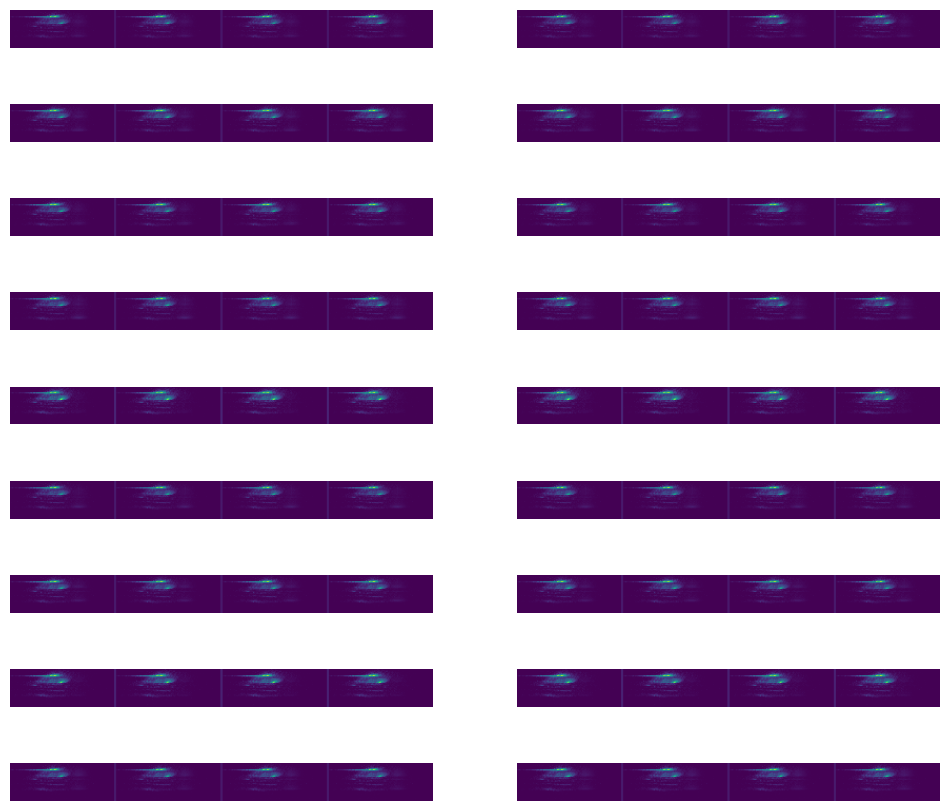

In [8]:
ds = DensityData(data_sw, lbk=config.lookback, h=config.horizon)
train_tl = TfmdLists(calculate_sample_idxs(splits[0], samples_per_simulation), 
                     DensityTupleTransform(ds))
valid_tl = TfmdLists(calculate_sample_idxs(splits[1], samples_per_simulation), 
                     DensityTupleTransform(ds))
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=config.bs, 
                             device=default_device())
dls.show_batch()
foo, bar = dls.one_batch()
len(foo), len(bar)

In [9]:
loss_func = StackLoss(MSELossFlat())

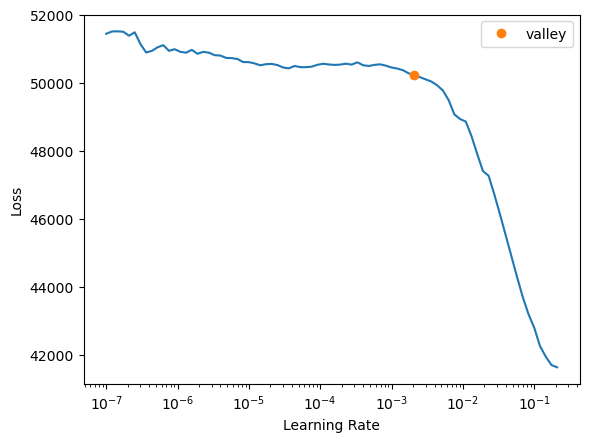

In [10]:
model = StackUnstack(SimpleModel()).to(default_device())
wandbc = WandbCallback(log_preds=False, log_model=False) if config.wandb.enabled else None
cbs = L() + wandbc
learn = Learner(dls, model, loss_func=loss_func, cbs=cbs)
lr_max = ifnone(config.lr_max, learn.lr_find())

In [11]:
learn.fit_one_cycle(config.n_epoch, lr_max=lr_max)

epoch,train_loss,valid_loss,time
0,49587.476562,47040.675781,00:11
1,33083.164062,13754.737305,00:11
2,16538.035156,5305.972656,00:11
3,8467.451172,3142.809326,00:11
4,4991.076660,2860.801025,00:11


In [30]:
p,t = learn.get_preds()
len(p), p[0].shape

(4, torch.Size([780, 1, 36, 99]))

In [37]:
def show_res(t, idx, figsize=(8,4)):
    density_seq = DensitySeq.create([t[i][idx] for i in range(len(t))])
    density_seq.show(figsize=figsize);

699


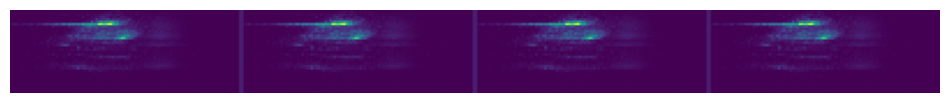

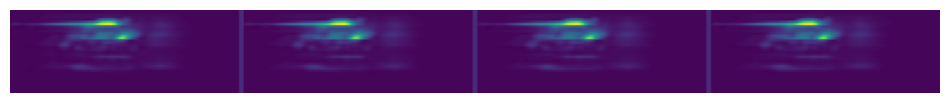

In [41]:
k = random.randint(0, dls.valid.n)
figsize=(12,8)
print(k)
show_res(t,k, figsize=figsize)
show_res(p,k, figsize=figsize)